In [ ]:
# import os
# import sys
# import matplotlib.pyplot as plt
# # add local lib to sys path for relative import
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

# # import pandas as pd
# from src import vis
# from src.log.common import read_pickle, TensorType
# import re
# from ipywidgets import interact, widgets,fixed, AppLayout
# import pandas as pd
# df = read_pickle('../test-data/numerics_df_v3.pkl')

# from functools import partial
# import time
# from typing import Callable, Dict
# import matplotlib
# import matplotlib.backend_bases
# import itertools
# import matplotlib.figure
# import numpy as np
# import traitlets
# import traitlets.utils
# import traitlets.utils.sentinel
# plt.switch_backend('ipympl')
# # Construct Widget Objects (containing widget and some state)




# class WidgetHolder:
        
#         def __init__(self, parent : widgets.Output, **kwargs) -> None:
#             self.parent = parent
#             self.widgets: Dict[str,widgets.Widget] = {
#                 **kwargs
#             }
#             self.hbox_layout = widgets.Layout(flex_flow='row',display='flex',**{'width': '100%','justify-content': 'space-around'})
#             self.container = widgets.HBox(
#                 children=list(self.widgets.values()),
#                 layout=self.hbox_layout
#             )

            
#         def _f(self,*args,**kwargs):
#             # so it only updates on the final point (for dropdown)
#             if args[0]['name'] == '_property_lock' and type(args[0]['old']) != traitlets.utils.sentinel.Sentinel and 'index' in args[0]['old'].keys():
#                 # overwrite redraw_fn args
#                 for k,v in self.widgets.items():
#                     self.redraw_fn_args[k] = v.value

#                 self.redraw_fn(**self.redraw_fn_args)
#             else:
#                 ...

#         def observe(self):
#             for k,v in self.widgets.items():
#                 v.observe(self._f)

#         def __getitem__(self,key) -> widgets.Widget:
#             return self.widgets[key]
        
#         def __setitem__(self,key: str, value: widgets.Widget) -> None:
#             # add widget to key
#             self.widgets[key] = value
#             # observe widget
#             self.widgets[key].observe(self._f)

#         def __delitem__(self,key: str) -> None:
#             # self.widgets[key].unobserve()
#             self.widgets[key].close()
#             self.widgets.__delitem__(key)


#         def set_current_redraw_function(self, f: Callable, fig: matplotlib.figure.Figure, **kwargs) -> None:
#             self.redraw_fn = partial(f,fig=fig)
#             self.redraw_fn_args = kwargs

#         def display(self):
#             self.parent.append_display_data(self.container)
#             self.parent.outputs = self.parent.outputs[-1:]

#         def nuke(self):
#             """Kill all widgets in WH"""
#             for k,v in self.widgets.items():
#                 v.close()
#             self.widgets = {}
#             self.container.close()
#             del self.container

#             # Also needs to kill Hboxes...

#         def rebuild(self,**kwargs):
#             self.widgets: Dict[str,widgets.Widget] = {
#                 **kwargs
#             }
#             self.container = widgets.HBox(
#                 children=list(self.widgets.values()),
#                 layout=self.hbox_layout
#             )
#             self.observe()
#             self.display()


#         def state(self) -> Dict:
#             return {k:v.value for k,v in self.widgets.items()}



# def _render_toolbar(rdf: Callable, drargs, hbox: widgets.HBox, WH: WidgetHolder, TOOLBAR: widgets.Output) -> WidgetHolder:
#     # delete all widgets
#     WH.nuke()
#     if rdf.__name__ == '_exp_hist_redraw':
#         #  Update ToolBar
#         del WH['scalar_metric']
#         hbox.close()
#         WH['kind'] = widgets.Dropdown(options=['bar','kde','line'], value='line')
#         WH.set_current_redraw_function(rdf, 
#             **drargs)
#         TOOLBAR.append_display_data(WH['kind'])
#         TOOLBAR.outputs = TOOLBAR.outputs[-1:]
        
#         ...
#     elif rdf.__name__ == '_global_scalar_redraw':
#         ...


# def _exp_hist_redraw(fig: matplotlib.figure.Figure, df: pd.DataFrame, layer: str, tt: TensorType, step: int, **kwargs):

#     # clear all axes from the figure
#     fig.clear()
#     # create new axes
#     new_ax = fig.gca()
#     kind = kwargs.pop('kind','line')
#     # Get required data & draw plot
#     plotter = vis._ExpHistPlotter(
#                     kind=kind,
#                     sp_kws=kwargs.pop('sp_kws',dict(n=10000,log_scale=2, bw_adjust=4, fill=True) if kind == 'kde' else {}),
#                     xtick_labelsize=kwargs.pop('xtick_labelsize',6),
#                     xtick_rotation=kwargs.pop('xtick_rotation',45),
#                     dtype_annotation=kwargs.pop('dtype_annotation',True),
#                     dtype_info=kwargs.pop('dtype_info',(True,True,True)),
#                     legend_kws = kwargs.pop('legend_kws',dict(fontsize=10,loc='upper right'))
#                 )
#     _df = plotter._query(df,layer,tt, step)
#     plotter._plot_single(_df,new_ax)
#     # X-axis isn't functioning correctly

#     fig.suptitle(f'Layer: {layer}, Step: {step}, TT: {tt}')

#     fig.canvas.draw_idle()

# def _global_scalar_redraw(fig: matplotlib.figure.Figure, df: pd.DataFrame, scalar_metric: str, tt: TensorType, inc: int,  **kwargs):

#     # clear figure
#     fig.clear()
#     # create new axes
#     new_ax = fig.gca()

#     plotter = vis._GlobalHeatmapPlotter(
#             x = kwargs.pop('x', ('metadata', 'step')),
#             y = kwargs.pop('y', ('metadata', 'name')),
#             scalar_metric=scalar_metric,
#             **kwargs
#             )
    
#     _df = plotter._query(df,tt,inc)
    
#     # create new axes
#     plotter._plot_single(
#         df=_df,
#         ax=new_ax
#     )

#     fig.suptitle(scalar_metric.upper())

#     fig.canvas.draw_idle()

# def interact_vis(f: Callable,width=1500 ,**kwargs) -> None:
#     # could make this general with the plot function passed in (and check which it is, etc...)
#     """
#         f (Callable) : The plotting function you wish to make interactive

#         kwargs: The arguements for provided vis function f 
    
#     """
#     # Accessible with-in the function scope
#     WH = None
    

#     # Onclick Event Handler for ScalarGlobalHeatmap
#     def sgh_onclick(event: matplotlib.backend_bases.MouseEvent):
#         nonlocal stack_num # for tracking plot state
#         nonlocal APP
#         # initial state of plot
#         DF = kwargs['df'] # not optional ever
#         TT = kwargs.get('tt',None)
#         INC = kwargs.get('inc',None)
#         SCALAR_METRIC = kwargs.get('scalar_metric',None)
#         LAYER = kwargs.get('layer',None)
#         STEP = kwargs.get('step', None)
#         # where is the mouse w.r.t to x-tickets / y-ticks (this will form the query)
#         if event.button == 1 and stack_num == 0:
#             stack_num = 1
#             tf, ind =  event.canvas.figure.axes[0].collections[0].contains(event)
#             if tf:
                
#                 # from the current fig get the x,y labels so that clicking can 
#                 # this breaks if not all values are displayed on the x or y-axis ...
#                 x_vals = [int(l.get_text()) for l in  event.canvas.figure.axes[0].get_xticklabels()]
#                 y_vals = [l.get_text() for l in event.canvas.figure.axes[0].get_yticklabels()]
#                 prod_xy = list(itertools.product(y_vals,x_vals))
#                 # use the index of the object in the mesh grid to get the query params (l_name, Step)
#                 layer, step = prod_xy[ind['ind'].item()]
#                 # clear all axes from the figure

#                 drargs = dict(fig=event.canvas.figure,
#                     df=DF,
#                     layer=layer,
#                     step=step,
#                     **WH.state())
#                 # could add **kwargs here...
#                 drf = _exp_hist_redraw

#                 drf(**drargs)

#                 # Update ToolBar
#                 WH.nuke()
#                 WH.set_current_redraw_function(drf, **drargs)
#                 WH.rebuild(
#                     kind = widgets.Dropdown(options=['bar','kde','line'], value='line')
#                 )
                
#         elif event.button == 3 and stack_num > 0 :
#             stack_num = 0
#             # Redraw Figure
#             drf = _global_scalar_redraw
#             drargs = dict(fig=event.canvas.figure,
#                 df=DF,
#                 tt=TT,
#                 scalar_metric=SCALAR_METRIC,
#                 inc=INC)
#             drf(**drargs)
                
#             WH.nuke()
#             WH.set_current_redraw_function(drf, **drargs)
#             WH.rebuild(
#                     scalar_metric = widgets.Dropdown(options=kwargs['df'].general_stats.columns.tolist() , value=SCALAR_METRIC),
#                     tt = widgets.Dropdown(options=kwargs['df'].metadata.grad.unique().tolist(), value=TT, description='Number:')
#             )
#     # Onclick Event Handler for Exponent Hist
#     def eh_onclick(event: matplotlib.backend_bases.MouseEvent):
#         ...

#     def sl_onclick(event: matplotlib.backend_bases.MouseEvent):
#         ...

#     assert isinstance(f,Callable), f'{f} is not Callable'

#     # Create figure
#     fig = f(**kwargs)
#     stack_num = 0   


#     # General Plot Formating
#     fig.figure.canvas.toolbar_visible = False
#     fig.figure.canvas.figure_title = False
#     fig.figure.canvas.header_visible = False
#     fig.figure.canvas.footer_visible = False
#     fig.figure.canvas.resizable = False


#     # Canvas output & Figure set to same size
#     APP = widgets.Output(layout={'width': f'{width}px','justify-content': 'space-around', 'overflow': 'scroll hidden'})
#     fig.figure.set_figwidth(width/fig.figure.dpi)
#     TOOLBAR = widgets.Output(layout={'width': '100%','justify-content': 'space-around'})
    

#     # Initial State of the interactive visualisation..
#     if f.__name__ == 'scalar_global_heatmap':

#         cid = fig.figure.canvas.mpl_connect('button_press_event', sgh_onclick)

#         # FN specific 
#         WH = WidgetHolder(parent=TOOLBAR,
#                           scalar_metric=widgets.Dropdown(options=kwargs['df'].general_stats.columns.tolist() , value=kwargs['scalar_metric']),
#                           tt=widgets.Dropdown(options=kwargs['df'].metadata.grad.unique().tolist(), value=kwargs['tt']))
#         WH.observe()
#         WH.set_current_redraw_function(_global_scalar_redraw, fig=fig.figure, **kwargs)
#         WH.display()
    
#     elif f.__name__ == 'exp_hist':
#         cid = fig.figure.canvas.mpl_connect('button_press_event', eh_onclick)


#         WH = WidgetHolder(parent=TOOLBAR,
#                           kind = widgets.Dropdown(options=['bar','kde','line'], value='bar'),
#                           tt=widgets.Dropdown(options=kwargs['df'].metadata.grad.unique().tolist(), value=kwargs['tt']),
#                           layer=  widgets.Dropdown(options=df.metadata.name.unique().tolist(), value = kwargs['layer']),
#                           step = widgets.Dropdown(options=df.metadata.step.unique().tolist(), value = kwargs['step'])
#                           )
    
#         WH.observe()
#         WH.set_current_redraw_function(_exp_hist_redraw, fig=fig.figure, **kwargs)
#         WH.display()



#         # raise NotImplementedError(f'{f.__name__} is not currently supported')
#     elif f.__name__ == 'scalar_line':
#         raise NotImplementedError(f'{f.__name__} is not currently supported')
#     else:
#         raise Exception(f'{f.__name__} is not a valid vis function')
        
        

        
#     # Add to master output...
#     # APP.append_display_data(TOOLBAR)
#     # APP.append_display_data(TOOLBAR)
#     APP.append_display_data(fig.figure.canvas)

    
#     display(TOOLBAR,APP)


In [ ]:
import os
import sys
import matplotlib.pyplot as plt
# add local lib to sys path for relative import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# import pandas as pd
from src import vis
from src.log.common import read_pickle, TensorType
import re
from ipywidgets import interact, widgets,fixed, AppLayout
import pandas as pd
df = read_pickle('../test-data/numerics_df_v3.pkl')


import seaborn as sns

# plt.switch_backend('inline')
# # fig = vis.scalar_line(
# #     df=df,
# #     layer='output',
# #     tt=None,
# #     scalar_metric=None
# # )

# g = vis.exp_hist(
#     df=df,
#     layer=re.compile('layers.0.f'),
#     tt=TensorType.Activation,
#     col_wrap= 3,
#     figsize=(14,12),
#     dtype_info = (False,False,True),
#     step=100
# )

# vis.interact_vis(
#     f=vis.scalar_global_heatmap,
#     width=1200,
#     df=df,
#     tt=TensorType.Activation,
#     scalar_metric='rm8',
#     inc=100)


vis.interact_vis(
    f=vis.exp_hist,
    width=1000,
    df=df,
    col_wrap = 3,
    layer='output',
    tt=TensorType.Activation,
    dtype_info = (False,False,True),
    step=100)


Output(layout=Layout(width='100%'), outputs=({'output_type': 'display_data', 'data': {'text/plain': "HBox(chil…

Output(layout=Layout(overflow='scroll hidden', width='1000px'), outputs=({'output_type': 'display_data', 'data…

['output', 'layers.0.attention.resid_dropout'] TensorType.Activation 100 {'col_wrap': 3, 'dtype_info': (False, False, True), 'kind': 'bar'}
('metadata', 'name')
{'squeeze': False, 'sharex': True, 'sharey': True, 'subplot_kw': {}, 'gridspec_kw': {}}
10.0
10.0
10.0
10.0
{'fontsize': 10, 'loc': 'upper right'} {'FLOAT8_E4M3FN - Smallest SubNormal: $2^{-9}$ (exp) | 0.00195312 (rv)': <matplotlib.lines.Line2D object at 0x12fcf83b0>}
10.0
10.0
200.0 10.0


/Users/colmb/Library/CloudStorage/OneDrive-Graphcore/code/debugging-tool/src/vis/_plots.py:38: RuntimeWarning: invalid value encountered in log2
  return f"$2^{{{int(np.log2(value))}}}$"


['output', 'layers.0.attention.resid_dropout'] TensorType.Activation 100 {'col_wrap': 3, 'dtype_info': (False, False, True), 'kind': 'bar'}
('metadata', 'name')
{'squeeze': False, 'sharex': True, 'sharey': True, 'subplot_kw': {}, 'gridspec_kw': {}}
10.0
10.0
10.0
10.0
{'fontsize': 10, 'loc': 'upper right'} {'FLOAT8_E4M3FN - Smallest SubNormal: $2^{-9}$ (exp) | 0.00195312 (rv)': <matplotlib.lines.Line2D object at 0x1300c7ef0>}
10.0
10.0
200.0 10.0
['output', 'layers.0.attention.resid_dropout', 'layers.0.feed_forward.dropout'] TensorType.Activation 100 {'col_wrap': 3, 'dtype_info': (False, False, True), 'kind': 'bar'}
('metadata', 'name')
{'squeeze': False, 'sharex': True, 'sharey': True, 'subplot_kw': {}, 'gridspec_kw': {}}
10.0
10.0
10.0
10.0
{'fontsize': 10, 'loc': 'upper right'} {'FLOAT8_E4M3FN - Smallest SubNormal: $2^{-9}$ (exp) | 0.00195312 (rv)': <matplotlib.lines.Line2D object at 0x12eb6b290>}
10.0
10.0
200.0 10.0
['output', 'layers.0.attention.resid_dropout', 'layers.0.feed_for

In [3]:
plt.ion()

In [4]:
g = vis.exp_hist(
    df=df,
    layer=re.compile('layers.0.attention'),
    tt=TensorType.Activation,
    # scalar_metric='min_abs'
    col_wrap= 2, 
    dtype_info = (False,False,True),
    figsize=(14,10),
    step=100
)
plt.show(g)

{'layers.0.attention_norm': <Axes: >, 'layers.0.attention.wq': <Axes: >, 'layers.0.attention.wk': <Axes: >, 'layers.0.attention.wv': <Axes: >, 'layers.0.attention.wo': <Axes: >, 'layers.0.attention.resid_dropout': <Axes: >}
14.0
14.0
14.0
{'fontsize': 10, 'loc': 'upper right'} {'FLOAT8_E4M3FN - Smallest SubNormal: $2^{-9}$ (exp) | 0.00195312 (rv)': <matplotlib.lines.Line2D object at 0x12a4095e0>}
14.0
14.0


<Figure size 1400x1000 with 6 Axes>

In [2]:
vis.interact_vis(
    f=vis.scalar_global_heatmap,
    width=1200,
    df=df,
    tt=TensorType.Activation,
    scalar_metric='rm8',
    inc=100)

Output(layout=Layout(width='100%'), outputs=({'output_type': 'display_data', 'data': {'text/plain': "HBox(chil…

Output(layout=Layout(overflow='scroll hidden', width='1200px'), outputs=({'output_type': 'display_data', 'data…

In [3]:
vis.interact_vis(
    f=vis.exp_hist,
    width=1000,
    df=df,
    col_wrap = 3,
    layer='output',
    tt=TensorType.Activation,
    dtype_info = (False,False,True),
    step=100)

Output(layout=Layout(width='100%'), outputs=({'output_type': 'display_data', 'data': {'text/plain': "HBox(chil…

Output(layout=Layout(overflow='scroll hidden', width='1000px'), outputs=({'output_type': 'display_data', 'data…

In [9]:
tuple(1)

TypeError: 'int' object is not iterable

In [2]:
import matplotlib.pyplot as plt



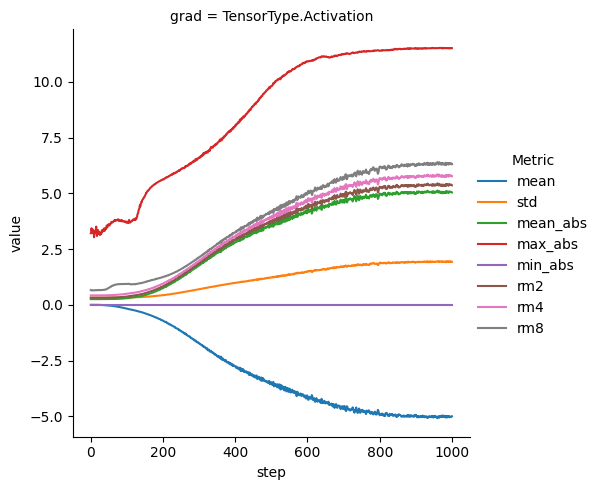

In [ ]:
# plt.switch_backend('module://matplotlib_inline.backend_inline')
plt.switch_backend('ipympl')

# out_box = widgets.Output(layout=widgets.Layout(width='100%', height='600px'))





def interact_exp_hist(df: pd.DataFrame, **kwargs):

    def f(df,plot,step, layer, tt,**kwargs):
        tt = list(tt)
        layer= list(layer)
        # print(layer)
        if len(layer) != 0:
            # out_box.clear_output()
            # with out_box:
                # with plt.ioff():
            fig = vis.exp_hist(
                df,
                layer=layer if len(layer) > 1 else layer[0],
                tt=tt if len(tt) > 1 else tt[0],
                step=step,
                kind=plot,
                **kwargs
                )
            _ = fig.tight_layout()

            plt.show(fig)


    # for fgn in plt.get_fignums():
        # plt.close(fgn)
    
    ptype_layout = widgets.Layout()

    ptype = widgets.Dropdown(
        options=['line','bar','kde'], 
        value='bar',
        layout=ptype_layout)

    step_sel_layout = widgets.Layout(width='95%')
    step_sel = widgets.IntSlider(
                 min=df.metadata.step.min(),
                 max=df.metadata.step.max(),
                 step=1,
                 value=df.metadata.step.min(),
                 layout=step_sel_layout
                 )
    
    layer_sel_layout = widgets.Layout(
        width='50%', 
        border='solid 1px')

    layer_sel = widgets.TagsInput(
        allowed_tags=df.metadata.name.unique().tolist(), 
        value = (df.metadata.name.unique()[0],),
        layout=layer_sel_layout)

    tt_sel_layout = widgets.Layout()
    tt_sel = widgets.SelectMultiple(
        options=df.metadata.grad.unique().tolist(), 
        value=(df.metadata.grad.unique().tolist()[0],),
        layout=tt_sel_layout)
    



    hbox_layout = widgets.Layout(width='95%',flex_flow='row',display='flex',align_items='stretch')
    hbox = widgets.HBox(children=[ptype,tt_sel,layer_sel],
                        layout=hbox_layout)

    

    ui = widgets.VBox(children=[step_sel,hbox])
    
    
    dct = dict(
          df = fixed(df),
          plot = ptype,
         step = step_sel,    
         layer=layer_sel,
         tt=tt_sel)
    dct.update({k: fixed(v) for k,v in kwargs.items()})
    
    out = widgets.interactive_output(f, dct)
    display(ui,out)

         

interact_exp_hist(df,col_wrap=4, figsize = (8,5),dtype_info=(True, False, True),dtype_annotation= True)




In [12]:
import os,sys
# add local lib to sys path for relative import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import seaborn as sns
from src import vis
import matplotlib.pyplot as plt

In [7]:
df = sns.load_dataset('tips')

In [9]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<Figure size 500x500 with 0 Axes>

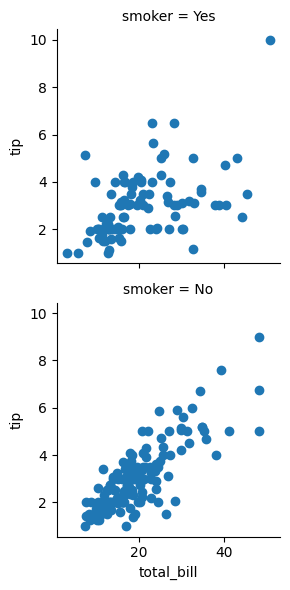

In [25]:
fig = plt.figure(figsize=(5,5))
g2 = vis.FG(df,row='smoker',figure=None)
g2.map(plt.scatter, "total_bill", "tip")

plt.show(g2)

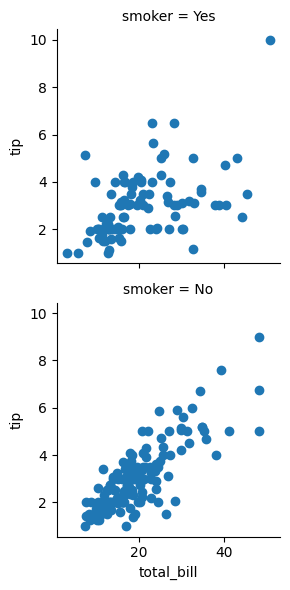

In [16]:
g = sns.FacetGrid(df,row='smoker')
g.map(plt.scatter, "total_bill", "tip")

In [ ]:
# Y-Axis, X-axis Formatting not consistent for kde plots
# Y-axis not consistent for hist

In [ ]:
from ipywidgets import AppLayout, FloatSlider, VBox, Checkbox, Layout, Button, Box, Label, SelectMultiple
import matplotlib.pyplot as plt
import numpy as np

plt.ioff()
plt.switch_backend('ipympl')

slider = FloatSlider(
    orientation='horizontal',
    description='Factor:',
    value=1.0,
    min=0.02,
    max=2.0
)

data = [f"data{i}" for i in range(50)]
checkboxes = [Checkbox(value=False, description=label) for label in data]
output = VBox(children=checkboxes)
# output.layout.max_width = '50%'
output.layout.margin = '50px 10% 0px 10%'
output.layout.overflow = 'scroll hidden'
output.layout.max_height = '200px'


slider.layout.margin = '0px 10% 0px 10%'
slider.layout.width = '40%'

fig = plt.figure()
fig.canvas.header_visible = False
fig.canvas.layout.min_height = '400px'
plt.title('Plotting: y=sin({} * x)'.format(slider.value))

x = np.linspace(0, 20, 500)

lines = plt.plot(x, np.sin(slider.value * x))

def update_lines(change):
    plt.title('Plotting: y=sin({} * x)'.format(change.new))
    lines[0].set_data(x, np.sin(change.new * x))
    fig.canvas.draw()
    fig.canvas.flush_events()

slider.observe(update_lines, names='value')

item_layout = Layout(height='100px', min_height='100px', min_width='40px')
items = [Checkbox(description=str(i), button_style='warning') for i in range(40)]
box_layout = Layout(overflow='scroll hidden',
                    # border='3px solid black',
                    width='',
                    height='',
                    flex_flow='row',
                    display='flex')
carousel = Box(children=items, layout=box_layout)
footer = VBox([Label('Scroll horizontally:'), carousel])

AppLayout(
    # height='300px',
    center=fig.canvas,
    header=footer,
)

In [ ]:
plt.figure().subplots()

# Interactive Hist App

In [ ]:
import seaborn as sns


In [ ]:
import traitlets
import traitlets.utils
import traitlets.utils.bunch
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

print(plt.get_fignums())

if len(plt.get_fignums()) > 0:
    plt.close(plt.gcf())



plt.rcParams['toolbar'] = 'None'
plt.ioff()
plt.switch_backend('ipympl')
step_slider = widgets.IntSlider(
                 min=0,
                 max=1000,
                 step=1,
                 value=0, layout=widgets.Layout(width="100%"))
plot_selector = widgets.Dropdown(options=['line','bar','kde'], value='bar', layout=widgets.Layout(width="95%"))
tt_selector = widgets.SelectMultiple(options=['a','b','c'], value=['a'], layout=widgets.Layout(width="95%"))
vbox_layout = widgets.Layout(min_height= '400px', min_width='200px')
layer_input = widgets.TagsInput(allowed_tags=['a','b','c'], value=['a'])
right_siderbar = widgets.VBox(
    layout=vbox_layout,
    children=[
    plot_selector,
    tt_selector,layer_input])

# figsize for sns.FacetGrid is the per plot figsize,
# it is then multiplied by n_rows (for height) & n_cols (for width)

fig=vis.exp_hist(
    df,
    layer=re.compile('layers.[0-5].feed_forward.w[1-3]'),
    tt=TensorType.Activation,
    step=1000,
    kind='kde',
    col_wrap=3,
    figsize=(3.9,3),
    dtype_info=(True, True, True),
    legend_kws = dict(fontsize=6,loc='upper right'),
    dtype_annotation= True,
)

print(fig.figure.get_figwidth())

fig.figure.canvas.header_visible = False
# fig.figure.canvas.toolbar = None
fig.figure.canvas.layout.min_height = '400px'
fig.figure.canvas.toolbar_visible = False

def update_fig(change: traitlets.utils.bunch.Bunch):

    fig.figure.canvas.draw()
    # fig.canvas.flush_events()

    ...

def onclick(event):
    if event.inaxes != None: # So clicking on the figure outside axes doesn't throw an error
        print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
            ('double' if event.dblclick else 'single', event.button,
            event.x, event.y, event.xdata, event.ydata))

cid = fig.figure.canvas.mpl_connect('button_press_event', onclick)

# fig.figure.canvas.



# step_slider.observe(update_fig,names='value')

step_slider.observe(lambda _: update_fig(1))


def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()


# fig.figure.canvas.mpl_connect('figure_enter_event', enter_figure)
# fig.figure.canvas.mpl_connect('figure_leave_event', leave_figure)
# fig.figure.canvas.mpl_connect('axes_enter_event', enter_axes)
# fig.figure.canvas.mpl_connect('axes_leave_event', leave_axes)
print(fig.figure.get_constrained_layout())


box_layout = widgets.Layout(display='flex',
                    flex_flow='row',
                    overflow='scroll',
                    align_items='stretch',
                    border = 'solid 2px',
                    width='100%')
box_auto = widgets.VBox(children=[fig.figure.canvas], layout=box_layout)

# ...
# right_sidebar, left_sidebar, header, footer, Center
al = widgets.AppLayout(
    header=step_slider,
    center= box_auto,
    pane_widths = [0,9,1],
    pane_heights = [0,10,10],
    right_sidebar = None,
    left_sidebar= right_siderbar,
    # footer=layer_input,
    grid_gap= "10px",
    justify_items='center',
    align_items='center',
)

fig.figure.canvas.toolbar_position = 'bottom'
fig.figure.canvas.resizable=False

# make canvas width equal that of the bounding box...



# print(fig.figure.canvas.get_width_height())
# fig.figure.set_figwidth(al.center.get_width_height()[0]/fig.figure.dpi)
# fig.figure.set_figheight(al.center.get_width_height()[1]/fig.figure.dpi)
fig.figure.canvas.draw()

display(al)

In [ ]:
import traitlets
import traitlets.utils
import traitlets.utils.bunch
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

print(plt.get_fignums())

if len(plt.get_fignums()) > 0:
    plt.close(plt.gcf())



plt.rcParams['toolbar'] = 'None'
plt.ioff()
plt.switch_backend('ipympl')
step_slider = widgets.IntSlider(
                 min=0,
                 max=1000,
                 step=1,
                 value=0, layout=widgets.Layout(width="100%"))
plot_selector = widgets.Dropdown(options=['line','bar','kde'], value='bar', layout=widgets.Layout(width="95%"))
tt_selector = widgets.SelectMultiple(options=['a','b','c'], value=['a'], layout=widgets.Layout(width="95%"))
vbox_layout = widgets.Layout(min_height= '400px', min_width='200px')
layer_input = widgets.TagsInput(allowed_tags=['a','b','c'], value=['a'])
right_siderbar = widgets.VBox(
    layout=vbox_layout,
    children=[
    plot_selector,
    tt_selector,layer_input])

# figsize for sns.FacetGrid is the per plot figsize,
# it is then multiplied by n_rows (for height) & n_cols (for width)

fig=vis.exp_hist(
    df,
    layer=re.compile('layers.[0-5].feed_forward.w[1-3]'),
    tt=TensorType.Activation,
    step=1000,
    kind='kde',
    col_wrap=3,
    figsize=(3.9,3),
    dtype_info=(True, True, True),
    legend_kws = dict(fontsize=6,loc='upper right'),
    dtype_annotation= True,
)

print(fig.figure.get_figwidth())

fig.figure.canvas.header_visible = False
# fig.figure.canvas.toolbar = None
fig.figure.canvas.layout.min_height = '400px'
fig.figure.canvas.toolbar_visible = False

def update_fig(change: traitlets.utils.bunch.Bunch):

    fig.figure.canvas.draw()
    # fig.canvas.flush_events()

    ...

def onclick(event):
    if event.inaxes != None: # So clicking on the figure outside axes doesn't throw an error
        print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
            ('double' if event.dblclick else 'single', event.button,
            event.x, event.y, event.xdata, event.ydata))

cid = fig.figure.canvas.mpl_connect('button_press_event', onclick)

# fig.figure.canvas.



# step_slider.observe(update_fig,names='value')

step_slider.observe(lambda _: update_fig(1))


def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()


# fig.figure.canvas.mpl_connect('figure_enter_event', enter_figure)
# fig.figure.canvas.mpl_connect('figure_leave_event', leave_figure)
# fig.figure.canvas.mpl_connect('axes_enter_event', enter_axes)
# fig.figure.canvas.mpl_connect('axes_leave_event', leave_axes)
print(fig.figure.get_constrained_layout())


box_layout = widgets.Layout(display='flex',
                    flex_flow='row',
                    overflow='scroll',
                    align_items='stretch',
                    border = 'solid 2px',
                    width='100%')
box_auto = widgets.VBox(children=[fig.figure.canvas], layout=box_layout)

# ...
# right_sidebar, left_sidebar, header, footer, Center
al = widgets.AppLayout(
    header=step_slider,
    center= box_auto,
    pane_widths = [0,9,1],
    pane_heights = [0,10,10],
    right_sidebar = None,
    left_sidebar= right_siderbar,
    # footer=layer_input,
    grid_gap= "10px",
    justify_items='center',
    align_items='center',
)

fig.figure.canvas.toolbar_position = 'bottom'
fig.figure.canvas.resizable=False

# make canvas width equal that of the bounding box...



# print(fig.figure.canvas.get_width_height())
# fig.figure.set_figwidth(al.center.get_width_height()[0]/fig.figure.dpi)
# fig.figure.set_figheight(al.center.get_width_height()[1]/fig.figure.dpi)
fig.figure.canvas.draw()

display(al)

In [ ]:
import traitlets
import traitlets.utils
import traitlets.utils.bunch
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

print(plt.get_fignums())

if len(plt.get_fignums()) > 0:
    for fg_n in plt.get_fignums():
        plt.close(fg_n)



plt.rcParams['toolbar'] = 'None'
plt.ioff()
plt.switch_backend('ipympl')
step_slider = widgets.IntSlider(
                 min=0,
                 max=1000,
                 step=1,
                 value=0, layout=widgets.Layout(width="100%"))
plot_selector = widgets.Dropdown(options=['line','bar','kde'], value='bar', layout=widgets.Layout(width="95%"))
tt_selector = widgets.SelectMultiple(options=['a','b','c'], value=['a'], layout=widgets.Layout(width="95%"))
vbox_layout = widgets.Layout(min_height= '400px', min_width='200px')
layer_input = widgets.TagsInput(allowed_tags=['a','b','c'], value=['a'])
right_siderbar = widgets.VBox(
    layout=vbox_layout,
    children=[
    plot_selector,
    tt_selector,layer_input])

# figsize for sns.FacetGrid is the per plot figsize,
# it is then multiplied by n_rows (for height) & n_cols (for width)

fig=vis.exp_hist(
    df,
    layer='layers.0.feed_forward.w1',
    tt=TensorType.Activation,
    step=1000,
    kind='kde',
    col_wrap=3,
    figsize=(12,3),
    xtick_labelsize=6,
    dtype_info=(True, True, True),
    legend_kws = dict(fontsize=6,loc='upper right'),
    dtype_annotation= True,
)

print(fig.figure.get_figwidth())

fig.figure.canvas.header_visible = False
# fig.figure.canvas.toolbar = None
fig.figure.canvas.layout.min_height = '400px'
fig.figure.canvas.toolbar_visible = False

def update_fig(change: traitlets.utils.bunch.Bunch):

    fig.figure.canvas.draw()
    # fig.canvas.flush_events()

    ...

def onclick(event):
    if event.inaxes != None: # So clicking on the figure outside axes doesn't throw an error
        print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
            ('double' if event.dblclick else 'single', event.button,
            event.x, event.y, event.xdata, event.ydata))

# cid = fig.figure.canvas.mpl_connect('button_press_event', onclick)

# fig.figure.canvas.



# step_slider.observe(update_fig,names='value')

step_slider.observe(lambda _: update_fig(1))


def enter_axes(event):
    print('enter_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()


# fig.figure.canvas.mpl_connect('figure_enter_event', enter_figure)
# fig.figure.canvas.mpl_connect('figure_leave_event', leave_figure)
# fig.figure.canvas.mpl_connect('axes_enter_event', enter_axes)
# fig.figure.canvas.mpl_connect('axes_leave_event', leave_axes)
# fig.figure.canvas.draw()
print(fig.figure.get_constrained_layout())


box_layout = widgets.Layout(display='flex',
                    flex_flow='row',
                    overflow='scroll',
                    align_items='stretch',
                    border = 'solid 2px',
                    width='100%')
box_auto = widgets.VBox(children=[fig.figure.canvas], layout=box_layout)

# ...
# right_sidebar, left_sidebar, header, footer, Center
al = widgets.AppLayout(
    header=step_slider,
    center= box_auto,
    pane_widths = [0,9,1],
    pane_heights = [0,10,10],
    right_sidebar = None,
    left_sidebar= right_siderbar,
    # footer=layer_input,
    grid_gap= "10px",
    justify_items='center',
    align_items='center',
)

fig.figure.canvas.toolbar_position = 'bottom'
fig.figure.canvas.resizable=False

# make canvas width equal that of the bounding box...



# print(fig.figure.canvas.get_width_height())
# fig.figure.set_figwidth(al.center.get_width_height()[0]/fig.figure.dpi)
# fig.figure.set_figheight(al.center.get_width_height()[1]/fig.figure.dpi)
fig.figure.canvas.draw()

display(al)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None

    def connect(self):
        """Connect to all the events we need."""
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        """Check whether mouse is over us; if so, store some data."""
        if event.inaxes != self.rect.axes:
            return
        contains, attrd = self.rect.contains(event)
        if not contains:
            return
        print('event contains', self.rect.xy)
        self.press = self.rect.xy, (event.xdata, event.ydata)

    def on_motion(self, event):
        """Move the rectangle if the mouse is over us."""
        if self.press is None or event.inaxes != self.rect.axes:
            return
        (x0, y0), (xpress, ypress) = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        # print(f'x0={x0}, xpress={xpress}, event.xdata={event.xdata}, '
        #       f'dx={dx}, x0+dx={x0+dx}')
        self.rect.set_x(x0+dx)
        self.rect.set_y(y0+dy)

        self.rect.figure.canvas.draw()

    def on_release(self, event):
        """Clear button press information."""
        self.press = None
        self.rect.figure.canvas.draw()

    def disconnect(self):
        """Disconnect all callbacks."""
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig, ax = plt.subplots()
rects = ax.bar(range(10), 20*np.random.rand(10))
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

In [ ]:
import numpy as np
class SnappingCursor:
    """
    A cross-hair cursor that snaps to the data point of a line, which is
    closest to the *x* position of the cursor.

    For simplicity, this assumes that *x* values of the data are sorted.
    """
    def __init__(self, ax, line):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        self.x, self.y = line.get_data()
        self._last_index = None
        # text location in axes coords
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            self._last_index = None
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            index = min(np.searchsorted(self.x, x), len(self.x) - 1)
            if index == self._last_index:
                return  # still on the same data point. Nothing to do.
            self._last_index = index
            x = self.x[index]
            y = self.y[index]
            # update the line positions
            self.horizontal_line.set_ydata([y])
            self.vertical_line.set_xdata([x])
            self.text.set_text(f'x={x:1.2f}, y={y:1.2f}')
            self.ax.figure.canvas.draw()


x = np.arange(0, 1, 0.01)
y = np.sin(2 * 2 * np.pi * x)

fig, ax = plt.subplots()
ax.set_title('Snapping cursor')
line, = ax.plot(x, y, 'o')
snap_cursor = SnappingCursor(ax, line)
fig.canvas.mpl_connect('motion_notify_event', snap_cursor.on_mouse_move)
plt.show()

In [8]:
import numpy as np
plt.switch_backend('ipympl')
# precomputing all images
x = np.linspace(0,np.pi,200)
y = np.linspace(0,10,200)
X,Y = np.meshgrid(x,y)
parameter = np.linspace(-5,5)
example_image_stack = np.sin(X)[None,:,:]+np.exp(np.cos(Y[None,:,:]*parameter[:,None,None]))


with plt.ioff():
    fig = plt.figure()
im = plt.imshow(example_image_stack[0])

def update(change):
    im.set_data(example_image_stack[change['new']])
    fig.canvas.draw_idle()
    
    
slider = widgets.IntSlider(value=0, min=0, max=len(parameter)-1)
slider.observe(update, names='value')
widgets.VBox([slider, fig.canvas])


/var/folders/vp/7bnnrt1s5wdf_kf27mrhlp4h0000gr/T/ipykernel_45212/11370350.py:2: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend('ipympl')
